In [24]:
import ast
import base64
import io
import json
import operator
import os
import re
import sqlite3
import uuid
from datetime import datetime
from pprint import pprint
from typing import Annotated, Any, Dict, Literal, Optional, TypedDict

import dotenv
import matplotlib.pyplot as plt
import pandas as pd
import psycopg2
import seaborn as sns
from langchain.tools import ToolRuntime, tool
from langchain_core.messages import (
    AIMessage,
    AnyMessage,
    HumanMessage,
    SystemMessage,
    ToolCall,
    ToolMessage,
)
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langgraph.graph import END, MessagesState, StateGraph, add_messages
from langgraph.prebuilt import ToolNode
from langsmith import Client
from pydantic import BaseModel, Field
from sqlalchemy import create_engine, text

dotenv.load_dotenv()
API_KEY = os.getenv("OPENROUTER_API_KEY")
BASE_URL = os.getenv("API_BASE_URL")
MODEL_NAME = "qwen/qwen3-coder-30b-a3b-instruct"  # os.getenv("MODEL_NAME")
LLM = ChatOpenAI(model=MODEL_NAME, base_url=BASE_URL, api_key=API_KEY)
ls_client = Client()

LANGSMITH_API_KEY = os.getenv("LANGSMITH_API_KEY")
LANGSMITH_PROJECT = os.getenv("LANGSMITH_PROJECT")
LANGSMITH_ENDPOINT = os.getenv("LANGSMITH_ENDPOINT")

DB_CONFIG = {
    "host": "localhost",
    "port": 5432,
    "database": "user_db",
    "user": "user",
    "password": "user",
}

### Agent state

In [ ]:
class Subtask(BaseModel):
    id: int = Field(default=0, description="ID подзадачи")
    description: str = Field(description="Описание подзадачи")
    result: str | list[dict[str, Any]] = Field(
        default_factory=list,
        description="Результаты выполнения подзадачи",
    )
    dependencies: list[int] = Field(
        default_factory=list,
        description="Список ID подзадач, от которых зависит эта подзадача",
    )


class AgentState(TypedDict):
    user_input: str
    plan: list[Subtask]
    cur_subtask_id: int
    worker_msg_history: list[AnyMessage]

### Planner

In [3]:
DB_PROMPT = """
СУБД: PostgreSQL 16
Тематика данных: пациенты, их диагнозы, рецепты и медикаменты в разрезе районов Санкт-Петербурга (СПб) и Ленинградской области (ЛО).
Особенности данных:

Все текстовые поля приведены к нижнему регистру.

Пол пациента: 'м' (мужчина), 'ж' (женщина).

В таблице явно представлены регионы: 'санкт-петербург', 'ленинградская область'.

Районы ЛО: ['колпино', 'ломоносов', 'сестрорецк', 'петродворец', 'павловск', 'пушкин', 'красное село', 'металлострой', 'зеленогорск', 'горелово'].

Районы СПб: ['пушкинский', 'выборгский', 'калининский', 'приморский', 'московский', 'кронштадтский', 'красносельский', 'кировский', 'адмиралтейский', 'фрунзенский', 'невский', 'красногвардейский', 'василеостровский', 'центральный', 'петроградский', 'курортный', 'колпинский', 'петродворцовый'].

Центральные районы СПб: ['адмиралтейский', 'василеостровский', 'центральный', 'петроградский'].

```sql
-- Пациенты
CREATE TABLE patients (
    id INTEGER PRIMARY KEY,
    дата_рождения DATE,
    пол VARCHAR(10),
    район_проживания VARCHAR(100),
    регион VARCHAR(100)
);

-- Диагнозы
CREATE TABLE diagnoses (
    код_мкб VARCHAR(20) PRIMARY KEY,
    название_диагноза TEXT,
    класс_заболевания TEXT
);

-- Медикаменты
CREATE TABLE medication (
    код_препарата INTEGER PRIMARY KEY,
    дозировка VARCHAR(100),
    торговое_название VARCHAR(100),
    стоимость FLOAT,
    мета_информация VARCHAR(200)
);

-- Рецепты
CREATE TABLE recipes (
    дата_рецепта DATE,
    код_диагноза VARCHAR(20),
    код_препарата INTEGER,
    id_пациента INTEGER,
    FOREIGN KEY (id_пациента) REFERENCES patients(id),
    FOREIGN KEY (код_диагноза) REFERENCES diagnoses(код_мкб),
    FOREIGN KEY (код_препарата) REFERENCES medication(код_препарата)
);
```
"""

In [4]:
PLANNER_SYS_PROMPT = """
Ты -- ИИ агент-планировщик в мультиагентной аналитической системе. 
Твоя задача -- разложить пользовательский запрос на структурированный и последовательный план действий.

## План действий должен соответствовать следующим требованиям:
- План должен состоять из атомарных шагов. Каждый шаг = одна чёткая подзадача;
- Каждый шаг должен требовать НЕ БОЛЕЕ одного вызова инструмента;
- План должен включать визуализации, если они помогут лучше выполнить запрос, даже если пользователь явно не просил их;
- Результаты предыдущих шагов могут использоваться в последующих;
- Ты не можешь получать *сырые данные без агрегации, т.к. данные слишком объёмные.
Используй сколь угодно сложный SQL вопрос -- но не допускай получение объёмных сырых данных.
- Сначала получение данных, а только потом построение графиков;
- Отсчёт шагов начинается с 0;
- Описание шага должно совмещать в себе тип действия, цель и ожидаемый результат;
- Заключающим шагом должен быть вывод итогов и интерпретация полученных данных.

*Сырые данные без агрегации -- это когда ты просто выбираешь все строки из таблицы без группировки или фильтрации:
получение всех пациентов без какой-либо агрегации по возрасту, полу, району и т.д. Например,
`SELECT * FROM patients WHERE регион = 'санкт-петербург';`

## Доступные инструменты и данные:
### Инструменты:
- `execute_sql` -- инструмент для выполнения SQL-запросов к БД, возвращает pd.DataFrame.to_dict() (список словарей);
- `plot_chart` -- инструмент на основе seaborn. Он работает с pd.DataFrame.to_dict() (список словарей). Данный инструмент
может визуализировать только следующие типы графиков: `["barplot" | "lineplot" | "scatterplot"]`.
Инструмент поддерживает параметр `hue`.

### Данные:
{db_prompt}


## Примеры:
### Хорошие примеры:
Исходный запрос: "распределение топ заболеваний в центральных районах среди мужчин и женщин"
0. Понять что такое центральные районы, используя доступные данные.
1. Получить топ-5 заболеваний в центральных районах среди мужчин и женщин: табличка
с колонками "район_проживания", "пол", "заболевание", "количество_пациентов".
3. Построить barplot с осями x="заболевание" и y="количество_пациентов" и hue="пол".
4. Построить barplot с осями x="заболевание" и y="количество_пациентов" и hue="район_проживания".
5. Кратко подвести итоги по полученным данным, ссылаясь на предыдущие шаги. Интерпретирровать результаты.

Исходный запрос: "какие заболевания чаще всего встречаются в ло?"
0. Получить топ-10 заболеваний в ленинградской области: табличка с колонками "заболевание", "количество_пациентов".
1. Построить barplot с осями x="заболевание" и y="количество_пациентов".
2. Кратко подвести итоги по полученным данным, ссылаясь на предыдущие шаги. Интерпретировать результаты.

Исходный запрос: "топ заболеваний в спб среди мужчин"
0. Получить топ-5 заболеваний в спб среди мужчин: табличка с колонками "заболевание", "количество_пациентов".
1. Построить barplot с осями x="заболевание" и y="количество_пациентов".
2. Кратко подвести итоги по полученным данным, ссылаясь на предыдущие шаги. Интерпретировать результаты.

Исходный запрос: "средний возраст среди больных вичом"
0. Получить мкб код для диагноза(ов) вич: табличка с колонками 'код_мкб' и 'название_диагноза'.
1. Получить средний возраст пациентов с диагнозом(ами): табличка с колонками 'название_диагноза' и 'средний_возраст'.
2. Кратко подвести итоги по полученным данным, ссылаясь на предыдущие шаги. Интерпретировать результаты.

### Плохие примеры:
Исходный запрос: "распределение топ заболеваний в центральных районах среди мужчин и женщин"
0. Понять какие данные доступны.
1. Получить заболевания в центральных районах среди мужчин и женщин: табличка
с колонками "район_проживания", "пол", "заболевание".
2. Построить histogram с осями x="заболевание" и hue="пол".
3. Построить histogram с осями x="заболевание" и hue="район_проживания".

Исходный запрос: "средний возраст среди больных вичом"
0. Получить список пациентов с диагнозом ВИЧ: табличка с колонками 'id', 'дата_рождения', 'пол', 'район_проживания', 'регион'.
1. Вычислить средний возраст пациентов с диагнозом ВИЧ: значение в годах.
2. Кратко подвести итоги по полученным данным, ссылаясь на предыдущие шаги. Интерпретировать результаты.
"""

In [5]:
class PlannerOutput(BaseModel):
    plan: list[str] = Field(description="Сгенерированный план из подзадач")


def planner_agent(state: AgentState) -> Dict[str, Any]:
    user_task = state["user_task"]
    llm_with_structured = LLM.with_structured_output(PlannerOutput, temperature=0.3)

    messages = [
        SystemMessage(content=PLANNER_SYS_PROMPT.format(db_prompt=DB_PROMPT)),
        HumanMessage(content=user_task),
    ]

    response = llm_with_structured.invoke(messages)

    for i, desc in enumerate(response.plan):
        response.plan[i] = SubTask(id=i, description=desc)

    plan = response.plan

    return {"plan": plan, "cur_subtask_id": 0}

In [55]:
# Test workflow
workflow = StateGraph(AgentState)

workflow.add_node("planner_agent", planner_agent)
workflow.set_entry_point("planner_agent")
workflow.add_edge("planner_agent", END)

agent_app = workflow.compile()

user_task = "чем болеют красном селе"
initial_state = {"user_task": user_task}
final_state = agent_app.invoke(initial_state)

print("Generated Plan:")
for subtask in final_state["plan"]:
    print(f"{subtask.description}")

Generated Plan:
0. Получить топ-10 заболеваний в красном селе: табличка с колонками 'заболевание', 'количество_пациентов'.
1. Построить barplot с осями x='заболевание' и y='количество_пациентов'.
2. Кратко подвести итоги по полученным данным, ссылаясь на предыдущие шаги. Интерпретировать результаты.


### Worker

#### Tools

In [ ]:
def get_db_engine():
    url = f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['database']}"
    return create_engine(url)


class ExecuteSQLInput(BaseModel):
    query: str = Field(description="SQL query to execute")


@tool(args_schema=ExecuteSQLInput)
def execute_sql_tool(query: str) -> list[dict[str, Any]] | str:
    """Выполняет SQL запрос и возвращает результат как список словарей."""
    try:
        engine = get_db_engine()
        # Ограничиваем, чтобы не вытащить всю БД случайно
        if "limit" not in query.lower():
            query = query.rstrip(";") + " LIMIT 25;"

        with engine.connect() as conn:
            df = pd.read_sql(text(query), conn)

        if df.empty:
            return "Query executed successfully but returned no results."

        return df.to_dict(orient="records")
    except Exception as e:
        return f"SQL Error: {str(e)}"


class PlotChartInput(BaseModel):
    data: list[dict] | str = Field(description="Data to plot as a list of dictionaries")
    chart_type: str = Field(description="Type of chart: barplot, lineplot, scatterplot")
    x: str = Field(description="Column name for x-axis")
    y: str = Field(description="Column name for y-axis")
    hue: Optional[str] = Field(default=None, description="Column name for hue (optional)")


@tool(args_schema=PlotChartInput)
def plot_chart_tool(data: list[dict], chart_type: str, x: str, y: str, hue: str = None) -> str:
    """Строит график и возвращает сообщение об успехе (или путь к файлу/base64)."""
    try:
        if isinstance(data, str):
            try:
                data = json.loads(data)
            except Exception:
                try:
                    data = ast.literal_eval(data)
                except Exception:
                    return "Plotting Error: Data is a string but not valid JSON."
        if not data:
            return "No data to plot."

        df = pd.DataFrame(data)
        plt.figure(figsize=(10, 6))

        if chart_type == "barplot":
            sns.barplot(data=df, x=x, y=y, hue=hue)
        elif chart_type == "lineplot":
            sns.lineplot(data=df, x=x, y=y, hue=hue)
        elif chart_type == "scatterplot":
            sns.scatterplot(data=df, x=x, y=y, hue=hue)
        else:
            return f"Unsupported chart type: {chart_type}"

        plt.title(f"{chart_type}: {y} by {x}")
        plt.xticks(rotation=45)
        plt.tight_layout()

        plt.savefig(f"plot_{x}_{y}.png")
        plt.close()
        return f"Chart {chart_type} (x={x}, y={y}) generated successfully."
    except Exception as e:
        return f"Plotting Error: {str(e)}"

#### Agent

In [12]:
WORKER_SYS_PROMPT = """
Ты -- ИИ агент-исполнитель в мультиагентной аналитической системе. 
Твоя задача -- выполнять подзадачи из плана, сгенерированного агентом-планировщиком.

## Тебе доступные следующие данные:
{db_prompt}

## Правила выполнения подзадач:
- Каждая подзадача требует выполнения НЕ БОЛЕЕ одного вызова инструмента
- ВСЕГДА возвращай data строго в формате JSON, с двойными кавычками. Нельзя использовать одинарные кавычки.
- Если выполняешь поиск в таблице diagnoses, используй регулярные выражения.
Текущая дата: {current_date}
"""


def worker_agent(state: AgentState) -> Dict[str, Any]:
    plan = state["plan"]
    cur_subtask_id = state["cur_subtask_id"]
    cur_subtask = plan[cur_subtask_id]
    cur_subtask_desc = cur_subtask.description

    messages = state["worker_msg_history"]

    if len(messages) == 0:
        messages.append(
            SystemMessage(
                content=WORKER_SYS_PROMPT.format(
                    db_prompt=DB_PROMPT, current_date=datetime.now().strftime("%Y-%m-%d")
                )
            )
        )

    messages.append(HumanMessage(content=cur_subtask_desc))

    llm_with_tools = LLM.bind_tools([execute_sql_tool, plot_chart_tool], temperature=0.3)

    result = None
    response = llm_with_tools.invoke(messages)
    messages.append(response)

    if response.tool_calls:
        tool_call = response.tool_calls[0]
        tool_name = tool_call["name"]

        if tool_name == "execute_sql_tool":
            result = execute_sql_tool.invoke(tool_call["args"])
            messages.append(ToolMessage(content=result, tool_call_id=tool_call["id"]))
        elif tool_name == "plot_chart_tool":
            result = plot_chart_tool.invoke(tool_call["args"])
            messages.append(ToolMessage(content=result, tool_call_id=tool_call["id"]))
        else:
            result = f"Error: undefined tool called '{tool_name}'."
            messages.append(ToolMessage(content=result, tool_call_id=tool_call["id"]))
    else:
        result = response.content

    plan[cur_subtask_id].result = result

    return {
        "worker_msg_history": messages,
        "cur_subtask_id": cur_subtask_id + 1,
        "plan": plan,
    }

In [13]:
def should_continue(state: AgentState) -> Literal["worker", "end"]:
    if state["cur_subtask_id"] == len(state["plan"]):
        return "end"
    return "worker"

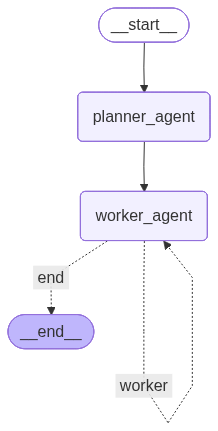

In [14]:
# Test workflow
workflow = StateGraph(AgentState)

workflow.add_node("planner_agent", planner_agent)
workflow.add_node("worker_agent", worker_agent)

workflow.set_entry_point("planner_agent")
workflow.add_edge("planner_agent", "worker_agent")
workflow.add_conditional_edges(
    "worker_agent",
    should_continue,
    {"worker": "worker_agent", "end": END},
)
agent_app = workflow.compile()
agent_app

In [22]:
user_task = "график кол-ва обращений за 2024 год по месяцам. Распределение обращений по топ районам"
initial_state = {"user_task": user_task, "worker_msg_history": []}
final_state = agent_app.invoke(initial_state)

pprint("Generated Plan:")
for subtask in final_state["plan"]:
    print(f"{subtask.id}. {subtask.description}")

pprint("\nResults:")
pprint(final_state["plan"][-1].result)

/tmp/ipykernel_47487/965048349.py:26: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if pd.api.types.is_datetime64_any_dtype(df[col]) or pd.api.types.is_datetime64tz_dtype(
/tmp/ipykernel_47487/965048349.py:26: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if pd.api.types.is_datetime64_any_dtype(df[col]) or pd.api.types.is_datetime64tz_dtype(


'Generated Plan:'
0. 0. Получить количество обращений (рецептов) за 2024 год по месяцам: табличка с колонками 'месяц' и 'количество_обращений'.
1. 1. Построить lineplot с осями x='месяц' и y='количество_обращений', чтобы визуализировать динамику обращений по месяцам.
2. 2. Получить топ-5 районов по количеству обращений за 2024 год: табличка с колонками 'район_проживания' и 'количество_обращений'.
3. 3. Построить barplot с осями x='район_проживания' и y='количество_обращений', чтобы визуализировать распределение обращений по топ районам.
4. 4. Кратко подвести итоги по полученным данным, ссылаясь на предыдущие шаги. Интерпретировать результаты.
'\nResults:'
('{\n'
 '    "summary": "На основе анализа данных за 2024 год можно сделать следующие '
 'выводы:\\n\\n1. Динамика обращений по месяцам: По линейному графику видно, '
 'что количество обращений постепенно увеличивается с января по декабрь, что '
 'может указывать на сезонные факторы или рост интереса к медицинским '
 'услугам.\\n\\n2.

In [23]:
final_state["plan"][0].result

[{'месяц': 1.0, 'количество_обращений': 14676},
 {'месяц': 2.0, 'количество_обращений': 12987},
 {'месяц': 3.0, 'количество_обращений': 13504},
 {'месяц': 4.0, 'количество_обращений': 15638},
 {'месяц': 5.0, 'количество_обращений': 15794},
 {'месяц': 6.0, 'количество_обращений': 14646},
 {'месяц': 7.0, 'количество_обращений': 16648},
 {'месяц': 8.0, 'количество_обращений': 14281},
 {'месяц': 9.0, 'количество_обращений': 15673},
 {'месяц': 10.0, 'количество_обращений': 18764},
 {'месяц': 11.0, 'количество_обращений': 15849},
 {'месяц': 12.0, 'количество_обращений': 18204}]